In [1]:
import torch
!pip install -qU torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting ./PROTEINS/PROTEINS.zip
Processing...


Dataset: PROTEINS(1113)
-----------------------
Number of graphs: 1113
Number of nodes: 5
Number of features: 3
Number of classes: 2


Done!


In [3]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

print('\nTrain loader:')
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: {batch}')

print('\nValidation loader:')
for i, batch in enumerate(val_loader):
    print(f' - Batch {i}: {batch}')

print('\nTest loader:')
for i, batch in enumerate(test_loader):
    print(f' - Batch {i}: {batch}')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Batch 0: DataBatch(edge_index=[2, 7646], x=[2070, 3], y=[64], batch=[2070], ptr=[65])
 - Batch 1: DataBatch(edge_index=[2, 10936], x=[2984, 3], y=[64], batch=[2984], ptr=[65])
 - Batch 2: DataBatch(edge_index=[2, 9092], x=[2511, 3], y=[64], batch=[2511], ptr=[65])
 - Batch 3: DataBatch(edge_index=[2, 8874], x=[2510, 3], y=[64], batch=[2510], ptr=[65])
 - Batch 4: DataBatch(edge_index=[2, 13412], x=[3378, 3], y=[64], batch=[3378], ptr=[65])
 - Batch 5: DataBatch(edge_index=[2, 8520], x=[2234, 3], y=[64], batch=[2234], ptr=[65])
 - Batch 6: DataBatch(edge_index=[2, 8466], x=[2207, 3], y=[64], batch=[2207], ptr=[65])
 - Batch 7: DataBatch(edge_index=[2, 9434], x=[2641, 3], y=[64], batch=[2641], ptr=[65])
 - Batch 8: DataBatch(edge_index=[2, 11142], x=[2983, 3], y=[64], batch=[2983], ptr=[65])
 - Batch 9: DataBatch(edge_index=[2, 8654], x=[2359, 3], y=[64], batch=[2359], ptr=[65])
 - Batch

In [4]:
import torch
torch.manual_seed(42)
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)

        return F.log_softmax(h, dim=1)

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super().__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)

In [5]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 100

    model.train()
    print(model.__doc__) # Printing model's docstring with name
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

            # Validation
            val_loss, val_acc = test(model, val_loader)

        # Print metrics every 20 epochs
        if(epoch % 20 == 0):
            print(f'Epoch: {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

In [6]:
gcn = GCN(dim_h=32)
gcn = train(gcn, train_loader)
test_loss, test_acc = test(gcn, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
print("")

gin = GIN(dim_h=32)
gin = train(gin, train_loader)
test_loss, test_acc = test(gin, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

GCN
Epoch:   0 | Train Loss: 0.69 | Train Acc: 55.88% | Val Loss: 0.68 | Val Acc: 62.38%
Epoch:  20 | Train Loss: 0.61 | Train Acc: 71.24% | Val Loss: 0.63 | Val Acc: 67.57%
Epoch:  40 | Train Loss: 0.60 | Train Acc: 71.02% | Val Loss: 0.63 | Val Acc: 70.76%
Epoch:  60 | Train Loss: 0.60 | Train Acc: 70.29% | Val Loss: 0.62 | Val Acc: 68.92%
Epoch:  80 | Train Loss: 0.60 | Train Acc: 70.00% | Val Loss: 0.64 | Val Acc: 63.16%
Epoch: 100 | Train Loss: 0.60 | Train Acc: 71.36% | Val Loss: 0.63 | Val Acc: 63.38%
Test Loss: 0.54 | Test Acc: 76.30%

GIN
Epoch:   0 | Train Loss: 0.98 | Train Acc: 60.26% | Val Loss: 0.55 | Val Acc: 63.95%
Epoch:  20 | Train Loss: 0.55 | Train Acc: 74.19% | Val Loss: 0.47 | Val Acc: 77.64%
Epoch:  40 | Train Loss: 0.51 | Train Acc: 75.72% | Val Loss: 0.46 | Val Acc: 75.02%
Epoch:  60 | Train Loss: 0.50 | Train Acc: 76.72% | Val Loss: 0.47 | Val Acc: 74.73%
Epoch:  80 | Train Loss: 0.48 | Train Acc: 77.61% | Val Loss: 0.46 | Val Acc: 78.21%
Epoch: 100 | Train Lo

For each protein, we get the final classification from our GNNs. We give
the prediction a green color if it is correct (red otherwise)

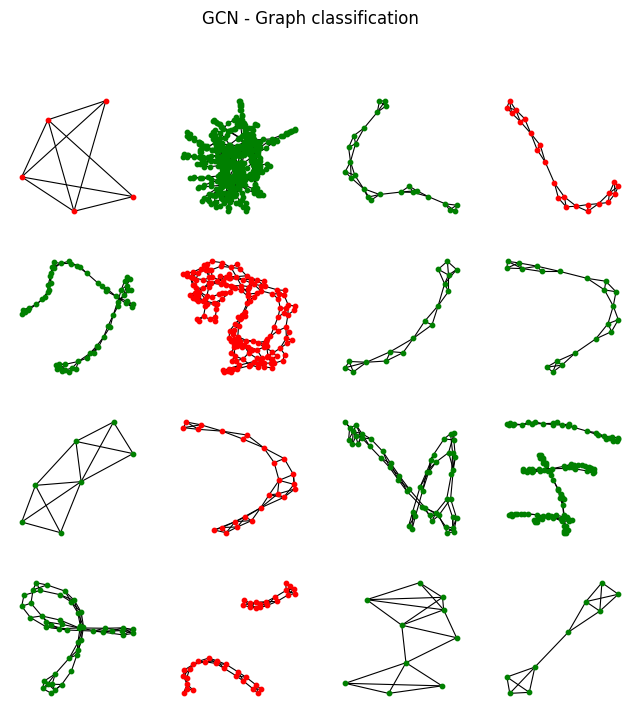

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

fig, ax = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('GCN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix])

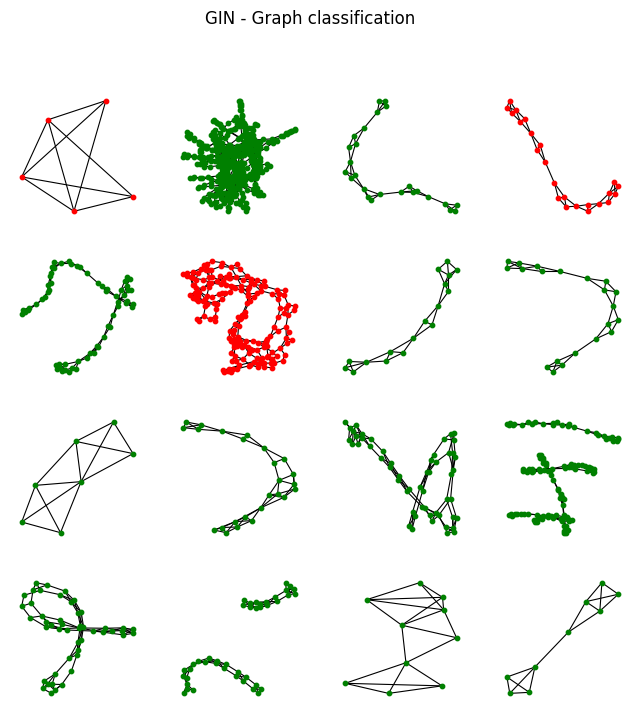

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

## Model-averaging technique (ensemble)

In [9]:
gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc_ens = 0

for data in test_loader:
    # Get classifications
    out_gcn = gcn(data.x, data.edge_index, data.batch)
    out_gin = gin(data.x, data.edge_index, data.batch)
    out_ens = (out_gcn + out_gin)/2

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc_ens += accuracy(out_ens.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc_ens*100:.2f}%')

GCN accuracy:     75.78%
GIN accuracy:     79.17%
GCN+GIN accuracy: 79.17%


In this scenario model averaging is as good as the GIN model is